In [10]:
import pandas as pd
import numpy as np
import sys
import h5py
import yaml
import torch
import glob
from tqdm import tqdm
import matplotlib.pyplot as plt

from torch.utils.data import DataLoader
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, recall_score, precision_score, f1_score
from sklearn.metrics import balanced_accuracy_score

sys.path.append('/mlodata1/lugeon/eeg_project/scripts')

from training.dataset import datasets
from training.representation import models

import seaborn as sns
sns.set_context("paper")
sns.set(font_scale = 1.6)
sns.set_style("white", {
    "font.family": "sans-serif",
    "font.serif": ['Helvetica'],
    "font.scale": 2
})
sns.set_style("ticks", {"xtick.major.size": 4,
                        "ytick.major.size": 4})

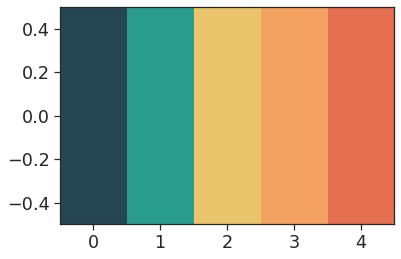

In [2]:
from matplotlib import colors
palette = ['#264653', '#2A9D8F','#E9C46A', '#F4A261', '#E76F51']
cmap = colors.ListedColormap(palette)

plt.imshow(np.arange(len(palette)).reshape(1, -1), aspect='auto', cmap=cmap,origin="lower")
plt.show()

In [11]:
hdf5_file = '/mlodata1/lugeon/dream_data/processed/madison_nrem_binary/dataset_256e.h5'


dataset = datasets.EEG_Image_Batch_Dataset(hdf5_file, 
                                           window=10, 
                                           slide=5, 
                                           batch_size=128, 
                                           shuffle=True, 
                                           return_metadata=True,
                                           exclude_subject=[],
                                           output_type='label')

with h5py.File(dataset.hdf5_file, 'r') as f:
    subjects = [s.decode('utf-8') for s in f['subject_name'][:]]
    
loader = DataLoader(dataset, batch_size=None, shuffle=False)
loader

In [12]:
def load_data(loader, model, device):

    encodings = []
    labels = []
    subject_ids = []
    trial_ids = []
    frame_ids = []
    sleep_stages = []
    elapsed_times = []

    with torch.no_grad():
        for input_batch, output_batch, metadata in loader:
            
            sid_batch, tid_batch, fid_batch, ss_batch, et_batch = metadata
                                
            # send to device
            input_batch = input_batch.to(device) 
                        
            # forward pass
            encoding_batch = model.encode(input_batch)
            
            if isinstance(model, models.MaskedAutoEncoder):
                encoding_batch = encoding_batch.mean(1) # mean across patches

            if isinstance(model, models.FineTuner) and isinstance(model.model, models.MaskedAutoEncoder):
                encoding_batch = encoding_batch.mean(1)
            
            if isinstance(model, models.AdverserialAutoencoder):
                encoding_batch = encoding_batch.mean(1)
            
            encodings.append(encoding_batch.cpu().detach().numpy())
            labels.append(output_batch.cpu().detach().numpy())
            subject_ids.append(sid_batch.cpu().detach().numpy())
            trial_ids.append(tid_batch.cpu().detach().numpy())
            frame_ids.append(fid_batch.cpu().detach().numpy())
            sleep_stages.append(ss_batch.cpu().detach().numpy())
            elapsed_times.append(et_batch.cpu().detach().numpy())
            
            del input_batch
            del output_batch
            del sid_batch
            del ss_batch
            del encoding_batch
            
    x = np.concatenate(encodings)
    y = np.concatenate(labels)
    s = np.concatenate(subject_ids)
    t = np.concatenate(trial_ids)
    f = np.concatenate(frame_ids)
    ss = np.concatenate(sleep_stages)
    et = np.concatenate(elapsed_times)

    df_data  = pd.DataFrame({'fid': f, 
                            'tid': t, 
                            'sid': s, 
                            'label': y,
                            'sleep_stage': ss,
                            'elapsed_time': et})

    # map N2 -> 0 and N3 -> 1
    df_data['sleep_stage'] = df_data.sleep_stage.apply(lambda ss: 1 if ss == 3 else 0)

    return df_data, x

In [14]:
def compute_scores(encodings, labels, subject_ids, subjects_name, clf, verbose=False):
    
    np.random.seed(0)
    
    encodings = np.array(encodings)
    labels = np.array(labels)    

    scores = np.zeros(len(labels))
    
    if verbose:
        pbar = tqdm(total=len(subjects_name))
    
    for sid, sname in enumerate(subjects_name):
        mask = subject_ids == sid
        mask_id = np.arange(len(labels))[mask]
        
        x_train = encodings[~mask]
        y_train = labels[~mask]

        x_test = encodings[mask]
            
        clf.fit(x_train, y_train)
        if isinstance(clf, RandomForestClassifier):
            y_score = clf.predict_proba(x_test)[:, 1]
        if isinstance(clf, LogisticRegression):
            y_score = clf.predict(x_test) 


        scores[mask_id] = y_score
        
        if verbose:
            pbar.update(1)
        
    return scores

In [15]:
def get_metrics(df, groupby_col, true_col, pred_col, score_col, agg=True):

    # remove subjects that are single-labelled
    condition = df.groupby(groupby_col)[true_col].nunique() == 1
    exclude_sid = condition.index[condition].to_list()
    df = df[df[groupby_col].apply(lambda s: s not in exclude_sid)]

    balanced_acc = df.groupby(groupby_col).apply(
        lambda g: balanced_accuracy_score(g[true_col], g[pred_col]))

    precision = df.groupby(groupby_col).apply(
        lambda g: precision_score(g[true_col], g[pred_col]))

    recall = df.groupby(groupby_col).apply(
        lambda g: recall_score(g[true_col], g[pred_col]))

    f1 = df.groupby(groupby_col).apply(
        lambda g: f1_score(g[true_col], g[pred_col]))

    rates = df.groupby(groupby_col).apply(
        lambda g: roc_curve(g[true_col], g[score_col]))

    rates = rates.apply(lambda r: [r[0].tolist(), r[1].tolist()])

    # mean area under the ROC curve
    aucs = [auc(fpr, tpr) for (fpr, tpr) in rates]

    if agg:
        metrics =  {
            'balanced_acc': [np.mean(balanced_acc), np.std(balanced_acc)],
            'precision': [np.mean(precision), np.std(precision)],
            'recall': [np.mean(recall), np.std(recall)],
            'f1': [np.mean(f1), np.std(f1)],
            'auc_roc': [np.mean(aucs), np.std(aucs)]
        }

    else:
        metrics =  {
            'balanced_acc': balanced_acc,
            'precision': precision,
            'recall': recall,
            'f1': f1,
            'auc_roc': aucs,
            'sid': df.groupby(groupby_col)[true_col].first().index.to_list()
        }

    return metrics

In [16]:
def metrics_per_epoch(loader, model, epochs_dir, clf, device):

    checkpoints = glob.glob(f'{epochs_dir}/*/checkpoint.pt')
    
    dream_classification = {}
    stage_classification = {}

    for chpt in tqdm(checkpoints, ncols=70):

        epoch = chpt.split('/')[-2]
        
        model.load_state_dict(torch.load(chpt))
        model.to(device)
        model.eval();

        df_data, encodings = load_data(loader, model, device)

        # dream scores
        dream_scores = compute_scores(encodings, 
                                       df_data.label, 
                                       df_data.sid, 
                                       subjects,
                                       clf)

        # sleep stage scores
        stage_scores = compute_scores(encodings, 
                                       df_data.sleep_stage,
                                       df_data.sid, 
                                       subjects, 
                                       clf)

        df_data['dream_score'] = dream_scores
        df_data['dream_pred'] = (dream_scores >= 0.5).astype(int)

        df_data['stage_score'] = stage_scores
        df_data['stage_pred'] = (stage_scores >= 0.5).astype(int)

        dream_metrics = get_metrics(df_data, 'sid', 'label', 'dream_pred', 'dream_score')
        stage_metrics = get_metrics(df_data, 'sid', 'sleep_stage', 'stage_pred', 'stage_score')

        dream_classification[int(epoch)] = dream_metrics
        stage_classification[int(epoch)] = stage_metrics

    df_dream = pd.DataFrame.from_dict(dream_classification, orient='index')
    df_stage = pd.DataFrame.from_dict(stage_classification, orient='index')

    df_dream.sort_index(inplace=True)
    df_stage.sort_index(inplace=True)

    return df_dream, df_stage

In [17]:
def overall_metrics(loader, model_dir, clf, device):

    with open(f'{model_dir}/train_config.yaml') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)

    # get model from model name
    model_function = getattr(models, config['model']['name'])
    model = model_function(**config['model']['kwargs'])

    if isinstance(model, models.MaskedAutoEncoder):
        model.masking_ratio = 0.
    if isinstance(model, models.AdverserialAutoencoder):
        model.model.masking_ratio = 0.

    model.to(device)
    model.eval();

    epochs_dir = f'{model_dir}/epochs'

    df_dream, df_stage = metrics_per_epoch(loader, model, epochs_dir, clf, device)

    return df_dream, df_stage

### Masking ratio

In [20]:
# same for all experiments

device = torch.device('cuda:0')
#clf = RandomForestClassifier(class_weight='balanced', n_estimators=1_000, max_depth=5, n_jobs=32)
clf = LogisticRegression(class_weight='balanced', max_iter=10_000, n_jobs=32)

In [55]:
result_dir = '/mlodata1/lugeon/eeg_project/results'

model_names_mask = [
    'masking_ratio/autoencoder_mask70',
    'masking_ratio/autoencoder_mask90',
    'masking_ratio/autoencoder_mask95',
    'masking_ratio/autoencoder_mask98'
]


dfs_masking_ratio = [overall_metrics(loader, f'{result_dir}/{n}', clf, device) for n in model_names_mask]

100%|█████████████████████████████████| 11/11 [07:34<00:00, 41.32s/it]


In [10]:
def get_values(df, col, index):
    return df[col].apply(lambda x: x[index]).values

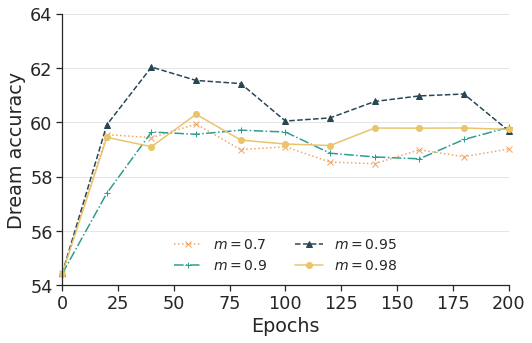

In [61]:
fig, ax = plt.subplots(figsize=(8, 5))

accs = [get_values(df[0], 'balanced_acc', 0) for df in dfs_masking_ratio]
accs = [100 * acc for acc in accs]
x = dfs_masking_ratio[0][0].index.astype(int).tolist()

alpha = 1

ax.plot(x, accs[0], 'x:', label=r'$m = 0.7$', c=cmap(3), alpha=alpha, clip_on=False)
ax.plot(x, accs[1], '+-.', label=r'$m = 0.9$', c=cmap(1), alpha=alpha, clip_on=False)
ax.plot(x, accs[2], '^--', label=r'$m = 0.95$', c=cmap(0), alpha=alpha, clip_on=False)
ax.plot(x, accs[3], 'o-', label=r'$m = 0.98$', c=cmap(2), alpha=alpha, clip_on=False)


ax.set_yticks([54, 56, 58, 60, 62, 64])

for tick in ax.get_yticks():
    ax.axhline(y=tick, color='black', lw=1, zorder=0, alpha=0.1)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

ax.set_xlabel('Epochs')
ax.set_ylabel('Dream accuracy')

plt.legend(frameon=False, loc='lower center', fontsize=14, ncol=2)

plt.xlim([0, 200])
plt.ylim([54, 64])

plt.savefig('img/dream_accuracy_masking.pdf', bbox_inches='tight')

plt.show()

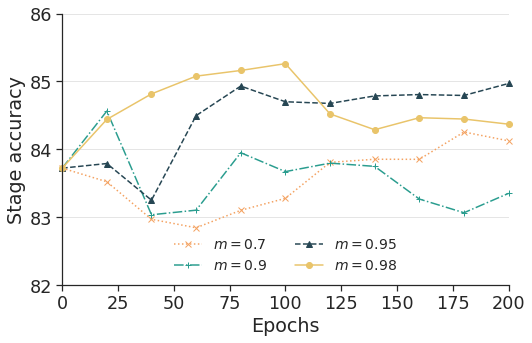

In [67]:
fig, ax = plt.subplots(figsize=(8, 5))

accs = [get_values(df[1], 'balanced_acc', 0) for df in dfs_masking_ratio]
accs = [100 * acc for acc in accs]
x = dfs_masking_ratio[0][0].index.astype(int).tolist()

alpha = 1

ax.plot(x, accs[0], 'x:', label=r'$m = 0.7$', c=cmap(3), alpha=alpha, clip_on=False)
ax.plot(x, accs[1], '+-.', label=r'$m = 0.9$', c=cmap(1), alpha=alpha, clip_on=False)
ax.plot(x, accs[2], '^--', label=r'$m = 0.95$', c=cmap(0), alpha=alpha, clip_on=False)
ax.plot(x, accs[3], 'o-', label=r'$m = 0.98$', c=cmap(2), alpha=alpha, clip_on=False)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

ax.set_xlabel('Epochs')
ax.set_ylabel('Stage accuracy')

ax.set_yticks([82, 83, 84, 85, 86])

for tick in ax.get_yticks():
    ax.axhline(y=tick, color='black', lw=1, zorder=0, alpha=0.1)

plt.legend(frameon=False, loc='lower right')

plt.xlim([0, 200])
plt.ylim([82, 86])

plt.legend(frameon=False, loc='lower center', fontsize=14, ncol=2)


plt.savefig('img/stage_accuracy_masking.pdf', bbox_inches='tight')


plt.show()

In [23]:
def find_max_acc(df):
    i = df.balanced_acc.apply(lambda a: a[0]).argmax()
    metrics = df.iloc[i].apply(lambda m: f'{100 * m[0]:.2f} +/- {100 * m[1]:.2f}')
    for m, v in zip(df.iloc[i].index, metrics):
        print(f'  {m:<15}: {v}')

In [70]:
task = 1 # 0 -> dream prediction, 1 -> stage prediction

for model_name, df in zip(model_names_mask, dfs_masking_ratio):
    print(model_name)
    find_max_acc(df[task])

masking_ratio/autoencoder_mask70
  balanced_acc   : 84.26 +/- 6.26
  precision      : 84.93 +/- 11.31
  recall         : 79.62 +/- 13.44
  f1             : 81.01 +/- 8.97
  auc_roc        : 90.94 +/- 6.19
masking_ratio/autoencoder_mask90
  balanced_acc   : 84.56 +/- 7.04
  precision      : 86.25 +/- 12.12
  recall         : 78.74 +/- 14.66
  f1             : 80.97 +/- 10.20
  auc_roc        : 91.19 +/- 5.89
masking_ratio/autoencoder_mask95
  balanced_acc   : 84.97 +/- 6.63
  precision      : 87.19 +/- 10.66
  recall         : 79.12 +/- 14.70
  f1             : 81.69 +/- 9.86
  auc_roc        : 92.21 +/- 5.96
masking_ratio/autoencoder_mask98
  balanced_acc   : 85.26 +/- 7.58
  precision      : 87.95 +/- 10.75
  recall         : 79.03 +/- 16.78
  f1             : 81.56 +/- 11.48
  auc_roc        : 92.05 +/- 6.22


### Patches temporal size

In [13]:
result_dir = '/mlodata1/lugeon/eeg_project/results'
model_names_temp = [
    'patch_temporal_size/autoencoder_time1',
    'patch_temporal_size/autoencoder_time2',
    'patch_temporal_size/autoencoder_time5',
    'patch_temporal_size/autoencoder_time10'
]

dfs_time_size = [overall_metrics(loader, f'{result_dir}/{n}', clf, device) for n in model_names_temp]

100%|█████████████████████████████████| 11/11 [07:15<00:00, 39.62s/it]


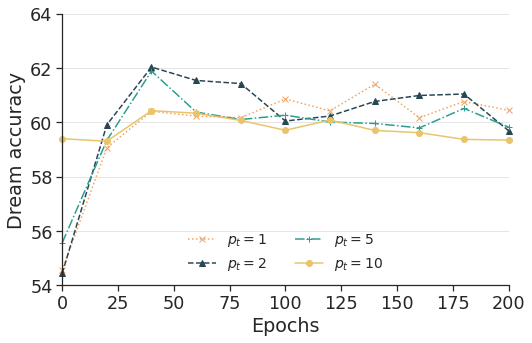

In [76]:
fig, ax = plt.subplots(figsize=(8, 5))

accs = [get_values(df[0], 'balanced_acc', 0) for df in dfs_time_size]
accs = [100 * acc for acc in accs]

x = dfs_time_size[0][0].index.astype(int).tolist()

alpha = 1

ax.plot(x, accs[0], 'x:', label=r'$p_t = 1$', c=cmap(3), alpha=alpha, clip_on=False)
ax.plot(x, accs[1], '^--', label=r'$p_t = 2$', c=cmap(0), alpha=alpha, clip_on=False)
ax.plot(x, accs[2], '+-.', label=r'$p_t = 5$', c=cmap(1), alpha=alpha, clip_on=False)
ax.plot(x, accs[3], 'o-', label=r'$p_t = 10$', c=cmap(2), alpha=alpha, clip_on=False)


ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

ax.set_xlabel('Epochs')
ax.set_ylabel('Dream accuracy')

plt.legend(frameon=False, loc='lower center', fontsize=14, ncol=2)

plt.xlim([0, 200])
plt.ylim([54, 64])

#ax.set_yticks([64, 65, 66, 67])


for tick in ax.get_yticks():
    ax.axhline(y=tick, color='black', lw=1, zorder=0, alpha=0.1)

plt.savefig('img/dream_accuracy_temporal.pdf', bbox_inches='tight')

plt.show()

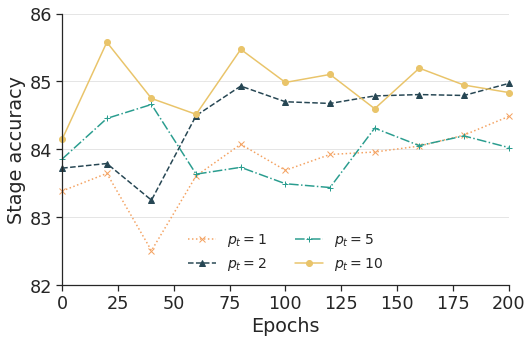

In [78]:
fig, ax = plt.subplots(figsize=(8, 5))

accs = [get_values(df[1], 'balanced_acc', 0) for df in dfs_time_size]
accs = [100 * acc for acc in accs]

x_ = dfs_time_size[0][0].index.astype(int).tolist()
x = dfs_time_size[1][0].index.astype(int).tolist()

ax.plot(x, accs[0], 'x:', label=r'$p_t = 1$', c=cmap(3), alpha=alpha, clip_on=False)
ax.plot(x, accs[1], '^--', label=r'$p_t = 2$', c=cmap(0), alpha=alpha, clip_on=False)
ax.plot(x, accs[2], '+-.', label=r'$p_t = 5$', c=cmap(1), alpha=alpha, clip_on=False)
ax.plot(x, accs[3], 'o-', label=r'$p_t = 10$', c=cmap(2), alpha=alpha, clip_on=False)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False) 

ax.set_xlabel('Epochs')
ax.set_ylabel('Stage accuracy')

plt.legend(frameon=False, loc='lower center', fontsize=14, ncol=2)

plt.xlim([0, 200])
plt.ylim([82, 86])

#ax.set_yticks([84, 85, 86, 87])

for tick in ax.get_yticks():
    ax.axhline(y=tick, color='black', lw=1, zorder=0, alpha=0.1)

plt.savefig('img/stage_accuracy_temporal.pdf', bbox_inches='tight')


plt.show()

### Architecture comparison

#### Masked autencoder

In [21]:
result_dir = '/mlodata1/lugeon/eeg_project/results'
model_name = 'masking_ratio/autoencoder_mask95'
model_dir = f'{result_dir}/{model_name}'

df_dream_mae, df_stage_mae = overall_metrics(loader, model_dir, clf, device)

100%|█████████████████████████████████| 11/11 [12:30<00:00, 68.21s/it]


In [24]:
find_max_acc(df_dream_mae)

  balanced_acc   : 59.37 +/- 6.15
  precision      : 59.43 +/- 24.71
  recall         : 61.60 +/- 11.88
  f1             : 57.31 +/- 18.57
  auc_roc        : 59.37 +/- 6.15


In [25]:
find_max_acc(df_stage_mae)

  balanced_acc   : 84.77 +/- 6.28
  precision      : 84.90 +/- 12.55
  recall         : 81.55 +/- 14.54
  f1             : 81.52 +/- 9.24
  auc_roc        : 84.77 +/- 6.28


#### Convolutional-based

In [15]:
result_dir = '/mlodata1/lugeon/eeg_project/results'
model_name = 'other_arch/ezgi_best'
model_dir = f'{result_dir}/{model_name}'

df_dream_cnn, df_stage_cnn = overall_metrics(loader, model_dir, clf, device)

100%|█████████████████████████████████| 11/11 [07:01<00:00, 38.35s/it]


In [16]:
find_max_acc(df_dream_cnn)

  balanced_acc   : 64.44 +/- 7.28
  precision      : 65.58 +/- 26.53
  recall         : 57.52 +/- 12.87
  f1             : 57.23 +/- 16.97
  auc_roc        : 65.98 +/- 9.94


In [17]:
find_max_acc(df_stage_cnn)

  balanced_acc   : 82.84 +/- 9.43
  precision      : 81.67 +/- 17.66
  recall         : 78.46 +/- 12.60
  f1             : 78.84 +/- 12.83
  auc_roc        : 88.76 +/- 9.01


#### Linear

In [18]:
result_dir = '/mlodata1/lugeon/eeg_project/results'
model_name = 'other_arch/linear'
model_dir = f'{result_dir}/{model_name}'

df_dream_linear, df_stage_linear = overall_metrics(loader, model_dir, clf, device)

100%|█████████████████████████████████| 11/11 [07:08<00:00, 38.96s/it]


In [19]:
find_max_acc(df_dream_linear)

  balanced_acc   : 64.54 +/- 6.14
  precision      : 66.70 +/- 24.97
  recall         : 57.81 +/- 11.15
  f1             : 58.30 +/- 16.33
  auc_roc        : 66.16 +/- 8.24


In [20]:
find_max_acc(df_stage_linear)

  balanced_acc   : 83.92 +/- 9.55
  precision      : 80.78 +/- 17.24
  recall         : 81.96 +/- 13.00
  f1             : 80.40 +/- 13.44
  auc_roc        : 89.54 +/- 9.35


#### No representation learning

In [21]:
clf_raw = RandomForestClassifier(class_weight='balanced', n_estimators=1_000, max_depth=5, n_jobs=32)

encodings = []
labels = []
subject_ids = []
trial_ids = []
frame_ids = []
sleep_stages = []
elapsed_times = []

with torch.no_grad():
    for input_batch, output_batch, metadata in loader:
        
        sid_batch, tid_batch, fid_batch, ss_batch, et_batch = metadata
                            
        encodings.append(input_batch.flatten(1, -1).cpu().detach().numpy())
        labels.append(output_batch.cpu().detach().numpy())
        subject_ids.append(sid_batch.cpu().detach().numpy())
        trial_ids.append(tid_batch.cpu().detach().numpy())
        frame_ids.append(fid_batch.cpu().detach().numpy())
        sleep_stages.append(ss_batch.cpu().detach().numpy())
        elapsed_times.append(et_batch.cpu().detach().numpy())
        
        del input_batch
        del output_batch
        del sid_batch
        del ss_batch      

x = np.concatenate(encodings)
y = np.concatenate(labels)
s = np.concatenate(subject_ids)
t = np.concatenate(trial_ids)
f = np.concatenate(frame_ids)
ss = np.concatenate(sleep_stages)
et = np.concatenate(elapsed_times)

df_data_raw  = pd.DataFrame({'fid': f, 
                             'tid': t, 
                             'sid': s, 
                             'label': y,
                             'sleep_stage': ss,
                             'elapsed_time': et})

# map N2 -> 0 and N3 -> 1
df_data_raw['sleep_stage'] = df_data_raw.sleep_stage.apply(lambda ss: 1 if ss == 3 else 0)

# dream scores
dream_scores = compute_scores(x, 
                              df_data_raw.label, 
                              df_data_raw.sid, 
                              subjects,
                              clf_raw)

# sleep stage scores
stage_scores = compute_scores(x, 
                              df_data_raw.sleep_stage,
                              df_data_raw.sid, 
                              subjects, 
                              clf_raw)

df_data_raw['dream_score'] = dream_scores
df_data_raw['dream_pred'] = (dream_scores >= 0.5).astype(int)

df_data_raw['stage_score'] = stage_scores
df_data_raw['stage_pred'] = (stage_scores >= 0.5).astype(int)

dream_metrics_raw = get_metrics(df_data_raw, 'sid', 'label', 'dream_pred', 'dream_score')
stage_metrics_raw = get_metrics(df_data_raw, 'sid', 'sleep_stage', 'stage_pred', 'stage_score')

In [24]:
for k, v in dream_metrics_raw.items():
    print(f'{k}: {v[0] * 100:.2f} +/- {v[1] * 100:.2f}')

balanced_acc: 65.15 +/- 6.03
precision: 66.77 +/- 25.00
recall: 59.52 +/- 15.73
f1: 58.10 +/- 15.42
auc_roc: 66.36 +/- 8.70


In [25]:
for k, v in stage_metrics_raw.items():
    print(f'{k}: {v[0] * 100:.2f} +/- {v[1] * 100:.2f}')

balanced_acc: 86.21 +/- 7.95
precision: 85.10 +/- 16.81
recall: 83.59 +/- 9.10
f1: 83.50 +/- 11.76
auc_roc: 91.87 +/- 8.13


### ROC Curve

In [25]:
result_dir = '/mlodata1/lugeon/eeg_project/results'
model_name = 'masking_ratio/autoencoder_mask95'
model_dir = f'{result_dir}/{model_name}'
epoch = 40

with open(f'{model_dir}/train_config.yaml') as file:
        config = yaml.load(file, Loader=yaml.FullLoader)

# get model from model name
model_function = getattr(models, config['model']['name'])
model = model_function(**config['model']['kwargs'])
model.load_state_dict(torch.load(f'{model_dir}/epochs/{epoch}/checkpoint.pt'))

if isinstance(model, models.MaskedAutoEncoder):
        model.masking_ratio = 0.
if isinstance(model, models.AdverserialAutoencoder):
        model.model.masking_ratio = 0.
        
model.to(device)
model.eval();

df_data, encodings = load_data(loader, model, device)

# dream scores
dream_scores = compute_scores(encodings, 
                              df_data.label, 
                              df_data.sid, 
                              subjects,
                              clf)

# sleep stage scores
stage_scores = compute_scores(encodings, 
                              df_data.sleep_stage,
                              df_data.sid, 
                              subjects, 
                              clf)

df_data['dream_score'] = dream_scores
df_data['dream_pred'] = (dream_scores >= 0.5).astype(int)

df_data['stage_score'] = stage_scores
df_data['stage_pred'] = (stage_scores >= 0.5).astype(int)

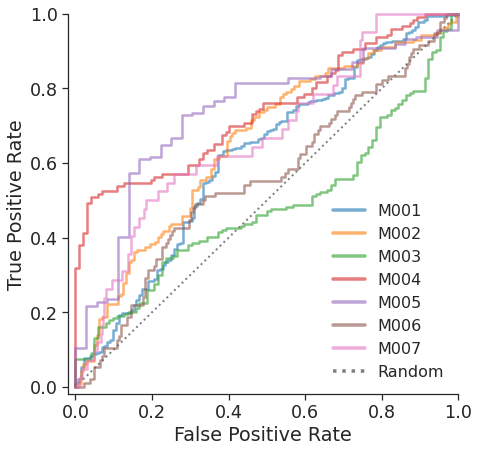

In [26]:
cmap_roc = plt.get_cmap('tab10')

fig, ax = plt.subplots(figsize=(7, 7)) 

rates = df_data.groupby('sid').apply(
    lambda g: roc_curve(g.label, g.dream_score))

rates = rates.apply(lambda r: [r[0].tolist(), r[1].tolist()])

i = 0
for r, s in zip(rates, subjects):
    fpr, tpr = r
    if fpr is not None:
        ax.plot(fpr, tpr, color=cmap_roc(i), label=s, alpha=0.6, lw=2.5, clip_on=False)
    i += 1
    
ax.plot([0, 1], [0, 1], label='Random', linestyle=':', color='black', alpha=0.5, lw=2, zorder=0, clip_on=False)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax.set_ylim([-0.02, 1])
ax.set_xlim([-0.02, 1])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

leg = plt.legend(frameon=False, loc='lower right', fontsize=16)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.5)

plt.savefig('img/roc_curve_dream.pdf', bbox_inches='tight')

plt.show()
    

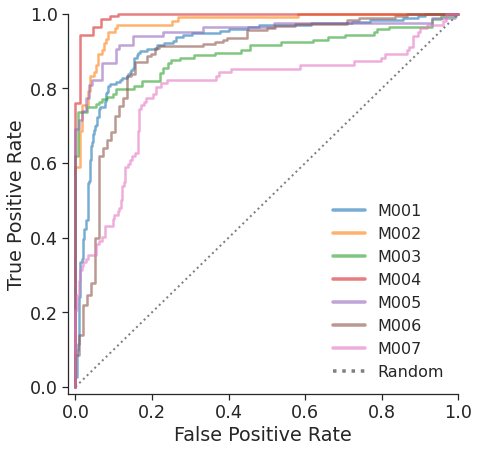

In [27]:
fig, ax = plt.subplots(figsize=(7, 7)) 

rates = df_data.groupby('sid').apply(
    lambda g: roc_curve(g.sleep_stage, g.stage_score))

rates = rates.apply(lambda r: [r[0].tolist(), r[1].tolist()])

i = 0
for r, s in zip(rates, subjects):
    fpr, tpr = r
    if fpr is not None:
        ax.plot(fpr, tpr, color=cmap_roc(i), label=s, alpha=0.6, lw=2.5, clip_on=False)
    i += 1
    
ax.plot([0, 1], [0, 1], label='Random', linestyle=':', color='black', alpha=0.5, lw=2, zorder=0, clip_on=False)

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

ax.set_ylim([-0.02, 1])
ax.set_xlim([-0.02, 1])

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

leg = plt.legend(frameon=False, loc='lower right', fontsize=16)
for legobj in leg.legendHandles:
    legobj.set_linewidth(3.5)

#plt.savefig('img/roc_curve_stage.pdf', bbox_inches='tight')

plt.show()
    

In [28]:
metrics = get_metrics(df_data, 'sid', 'label', 'dream_pred', 'dream_score', agg=False)
df_metrics = pd.DataFrame(metrics)
df_metrics['subject'] = df_metrics.sid.apply(lambda s: subjects[s])
df_metrics['subject'] = df_metrics.sid.apply(lambda s: subjects[s])

df_metrics.applymap(lambda x: f'{x * 100:.2f}' if type(x) == float else x)


,balanced_acc,precision,recall,f1,auc_roc,sid,subject
sid,,,,,,,
0,58.80,83.33,50.93,63.22,61.64,0,M001
1,63.19,62.18,67.36,64.67,65.22,1,M002
2,54.67,69.57,36.78,48.12,48.06,2,M003
3,72.27,89.19,52.38,66.00,74.05,3,M004
4,69.60,89.73,80.86,85.06,73.30,4,M005
5,57.61,43.88,44.79,44.33,55.52,5,M006
6,58.08,14.73,78.57,24.81,66.88,6,M007


In [29]:
dream_metrics = get_metrics(df_data, 'sid', 'label', 'dream_pred', 'dream_score', agg=True)
for k, v in dream_metrics.items():
    print(f'{k}: {v[0] * 100:.2f} +/- {v[1] * 100:.2f}')

balanced_acc: 62.03 +/- 6.13
precision: 64.66 +/- 25.45
recall: 58.81 +/- 15.74
f1: 56.60 +/- 17.89
auc_roc: 63.52 +/- 8.68


In [30]:
stage_metrics = get_metrics(df_data, 'sid', 'sleep_stage', 'stage_pred', 'stage_score', agg=True)
for k, v in stage_metrics.items():
    print(f'{k}: {v[0] * 100:.2f} +/- {v[1] * 100:.2f}')

balanced_acc: 83.25 +/- 7.44
precision: 85.89 +/- 12.05
recall: 76.99 +/- 16.03
f1: 79.61 +/- 11.64
auc_roc: 91.70 +/- 6.11


### Majority voting and cofounding variables

In [32]:
df_data.head()

,fid,tid,sid,label,sleep_stage,elapsed_time,dream_score,dream_pred,stage_score,stage_pred
0,15,2,5,1,1,399,0.359408,0,0.782132,1
1,15,36,5,0,1,20,0.365680,0,0.847790,1
2,0,30,6,0,0,288,0.607261,1,0.289029,0
3,25,19,0,1,1,176,0.225304,0,0.905560,1
4,5,35,0,1,0,17,0.662393,1,0.158422,0


In [38]:
trial_preds = df_data.groupby(['sid', 'tid']).dream_pred.apply(
    lambda p: sum(p) / len(p)
    ).to_frame().reset_index().rename(columns={'dream_pred': 'majority_score'})

trial_preds = trial_preds.merge(
    df_data[['sid', 'tid', 'label', 'elapsed_time', 'sleep_stage']].drop_duplicates(['sid', 'tid']), 
    how='left', on=['sid', 'tid'])

trial_preds['majority_pred'] = (trial_preds.majority_score >= 0.5).astype(int)

majority_acc = trial_preds.groupby('sid').apply(lambda g: sum(g.majority_pred == g.label) /g.shape[0])
print(f'Trial majority accuracy: {np.mean(majority_acc) * 100 :.2f} +/- {np.std(majority_acc) * 100:.2f}')

Trial majority accuracy: 62.57 +/- 13.19


In [127]:
correct = trial_preds[trial_preds.label == trial_preds.majority_pred] \
    .value_counts(['label', 'sleep_stage'])

incorrect = trial_preds[trial_preds.label != trial_preds.majority_pred] \
    .value_counts(['label', 'sleep_stage'])
    
correct = correct / correct.sum() * 100
incorrect = incorrect / incorrect.sum() * 100

In [128]:
correct

label  sleep_stage
1      0              49.545455
0      1              32.727273
       0              10.909091
1      1               6.818182
dtype: float64

In [129]:
incorrect

label  sleep_stage
0      0              34.027778
1      1              33.333333
       0              16.666667
0      1              15.972222
dtype: float64

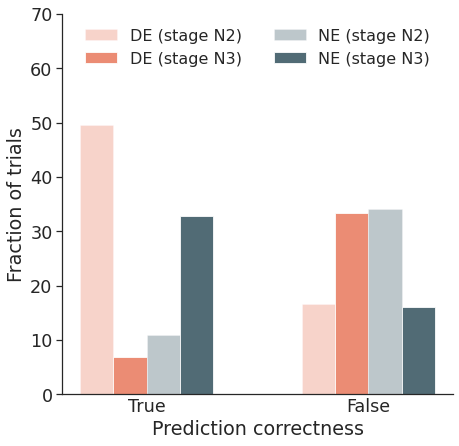

In [124]:
from operator import length_hint


fig, ax = plt.subplots(figsize=(7, 7))

x = [0, 1]
width = 0.15
x_offset = - 3 * width / 2


previous_correct = 0
previous_incorrect = 0

colors = [cmap(0), cmap(4)]
alphas = [0.3, 0.8]

label_names = ['NE', 'DE']
stage_names = ['N2', 'N3']

i = 0
for label in [1, 0]:
    for stage in [0, 1]:
           
       bar_label = f'{label_names[label]} (stage {stage_names[stage]})'
       
       x = x_offset + i * width
        
       ax.bar(0 + x, correct.loc[label, stage], width, 
              
              color=colors[label], alpha=alphas[stage], label=bar_label)
       ax.bar(1 + x, incorrect.loc[label, stage], width, 
              color=colors[label], alpha=alphas[stage])
       
       i += 1
        
       
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

#ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 70])

ax.set_xticks([0, 1])
ax.set_xticklabels(['True', 'False'])
ax.tick_params(axis='x', length=0)

ax.set_xlabel('Prediction correctness')
ax.set_ylabel('Fraction of trials')

plt.legend(frameon=False, ncol=2, loc='upper center', fontsize=16)

plt.savefig('img/prediction_distribution.pdf', bbox_inches='tight')
        
plt.show()

In [140]:
n2

,sid,tid,majority_score,label,elapsed_time,sleep_stage,majority_pred
4,0,4,1.000000,1,38,0,1
5,0,5,1.000000,1,86,0,1
6,0,6,1.000000,1,170,0,1
7,0,7,0.666667,1,193,0,1
8,0,8,1.000000,1,208,0,1
...,...,...,...,...,...,...,...
356,6,50,1.000000,1,445,0,1
358,6,52,0.833333,0,55,0,1
359,6,53,0.666667,0,74,0,1
360,6,54,0.500000,1,94,0,1


In [148]:
n2 = trial_preds[trial_preds.sleep_stage == 0]
correct_n2 = n2.groupby(['sid']).apply(lambda g: (g.label == g.majority_pred).sum() / g.shape[0])
correct_n2.mean(), correct_n2.std()

(0.6885600270435047, 0.2189636372998997)

In [149]:
n3 = trial_preds[trial_preds.sleep_stage == 1]
correct_n3 = n3.groupby(['sid']).apply(lambda g: (g.label == g.majority_pred).sum() / g.shape[0])
correct_n3.mean(), correct_n3.std()

(0.5468475609037444, 0.1180973639521373)

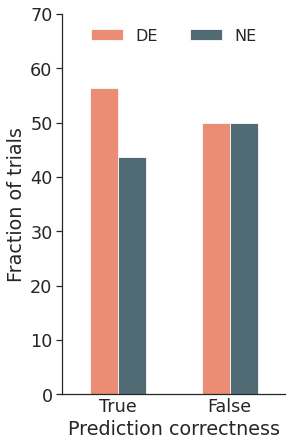

In [136]:
fig, ax = plt.subplots(figsize=(4, 7))

x = [0, 1]
width = 0.25
x_offset = - width / 2


previous_correct = 0
previous_incorrect = 0

colors = [cmap(0), cmap(4)]
alphas = [0.3, 0.8]

label_names = ['NE', 'DE']

i = 0
for label in [1, 0]:
           
       bar_label = f'{label_names[label]}'

       x = x_offset + i * width
       
       correct_value = correct.loc[label, :].sum()
       incorrect_value = incorrect.loc[label, :].sum()
                     
       ax.bar(0 + x, correct_value, width, 
              color=colors[label], alpha=alphas[stage], label=bar_label)
       ax.bar(1 + x, incorrect_value, width, 
              color=colors[label], alpha=alphas[stage])
              
       i += 1
              
       
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 70])

ax.set_xticks([0, 1])
ax.set_xticklabels(['True', 'False'])
ax.tick_params(axis='x', length=0)

ax.set_xlabel('Prediction correctness')
ax.set_ylabel('Fraction of trials')

plt.legend(frameon=False, ncol=2, loc='upper center', fontsize=16)

plt.savefig('img/prediction_distribution.pdf', bbox_inches='tight')
        
plt.show()

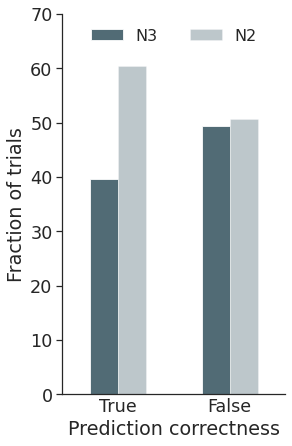

In [138]:
fig, ax = plt.subplots(figsize=(4, 7))

x = [0, 1]
width = 0.25
x_offset = - width / 2

colors = [cmap(0), cmap(4)]
alphas = [0.3, 0.8]

stage_names = ['N2', 'N3']

i = 0
for stage in [1, 0]:
           
       bar_label = f'{stage_names[stage]}'

       x = x_offset + i * width
       
       correct_value = correct.loc[:, stage].sum()
       incorrect_value = incorrect.loc[:, stage].sum()
                     
       ax.bar(0 + x, correct_value, width, 
              color=colors[label], alpha=alphas[stage], label=bar_label)
       ax.bar(1 + x, incorrect_value, width, 
              color=colors[label], alpha=alphas[stage])
              
       i += 1
              
       
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xlim([-0.5, 1.5])
ax.set_ylim([0, 70])

ax.set_xticks([0, 1])
ax.set_xticklabels(['True', 'False'])
ax.tick_params(axis='x', length=0)

ax.set_xlabel('Prediction correctness')
ax.set_ylabel('Fraction of trials')

plt.legend(frameon=False, ncol=2, loc='upper center', fontsize=16)

plt.savefig('img/prediction_distribution.pdf', bbox_inches='tight')
        
plt.show()

### Electrodes restriction

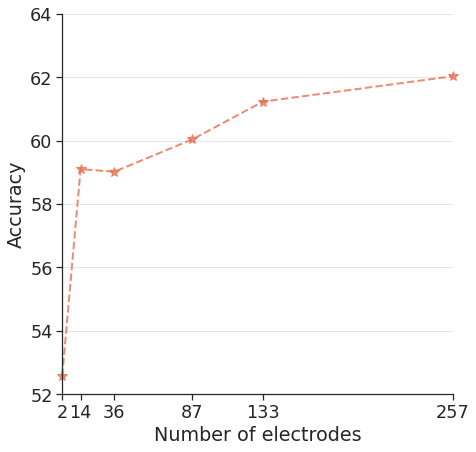

In [197]:
n_electrodes = [2, 14, 36, 87, 133, 257]
electrodes_acc = [52.58, 59.10, 59.02, 60.04, 61.23, 62.03]

fig, ax = plt.subplots(figsize=(7, 7))

ax.plot(n_electrodes, electrodes_acc, 
        ls='--', marker='*', clip_on=False, color=cmap(4), alpha=0.8, lw=2, ms=10)

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

ax.set_xticks(n_electrodes)
ax.set_yticks([52, 54, 56, 58, 60, 62, 64])
ax.set_xlim([2, 257])
ax.set_ylim([52, 64])


for tick in ax.get_yticks():
    ax.axhline(y=tick, color='black', lw=1, zorder=0, alpha=0.1)
    
        
plt.xlabel('Number of electrodes')
plt.ylabel('Accuracy')


plt.savefig('img/acc_vs_nelectrodes.pdf', bbox_inches='tight')


plt.show()


### Threshold increase

In [103]:
deltas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3]
acc_de_delta = []
acc_ne_delta = []
de_drop_rate = []
ne_drop_rate = []

de_support = df_data[df_data.dream_score >= 0.5].shape[0]
ne_support = df_data[df_data.dream_score < 0.5].shape[0]


for d in deltas:

    if df_data[df_data.dream_score >= 0.5 + d].sid.nunique() != 7:
        pass
    else:
        acc_de = df_data[df_data.dream_score >= 0.5 + d].groupby('sid') \
            .apply(lambda g: g[g.label == 1].shape[0] / g.shape[0])

        acc_de_delta.append(acc_de.mean())
        de_drop_rate.append(1 - df_data[df_data.dream_score >= 0.5 + d].shape[0] / de_support)

    if df_data[df_data.dream_score < 0.5 - d].sid.nunique() != 7:
        pass
    else:
        acc_ne = df_data[df_data.dream_score < 0.5 - d].groupby('sid') \
            .apply(lambda g: g[g.label == 0].shape[0] / g.shape[0])
        acc_ne_delta.append(acc_ne.mean())

        ne_drop_rate.append(1 - df_data[df_data.dream_score < 0.5 - d].shape[0] / ne_support)


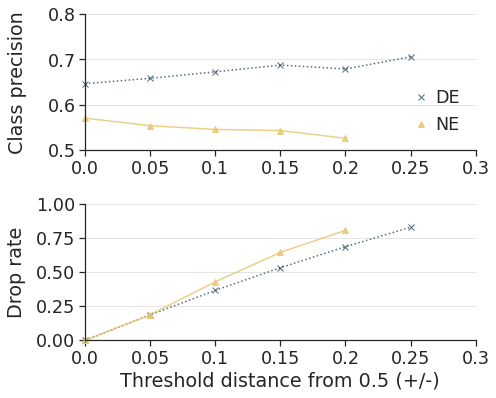

In [104]:
fig, axs = plt.subplots(2, 1, figsize=(7, 6))

x = np.arange(len(acc_de_delta))
axs[0].plot(x, acc_de_delta, 'x:', label='DE', c=cmap(0), alpha=0.8, clip_on=False)
axs[1].plot(x, de_drop_rate, 'x:', label='DE', c=cmap(0), alpha=0.8, clip_on=False)

x = np.arange(len(acc_ne_delta))
axs[0].plot(x, acc_ne_delta, '^-', label='NE', c=cmap(2), alpha=0.8, clip_on=False)
axs[1].plot(x, ne_drop_rate, '^-', label='NE', c=cmap(2), alpha=0.8, clip_on=False)

axs[0].set_ylim([0.5, 0.8])
axs[1].set_ylim([0, 1])

axs[0].set_xlim([0, 0.2])
axs[1].set_xlim([0, 0.2])

axs[0].legend(frameon=False, loc='lower right', handlelength=0)

axs[0].set_ylabel('Class precision', labelpad=20)
axs[1].set_ylabel('Drop rate', labelpad=10)
axs[1].set_xlabel('Threshold distance from 0.5 (+/-)')

axs[0].set_yticks([0.5, 0.6, 0.7, 0.8])
axs[1].set_yticks([0.0, 0.25, 0.5, 0.75, 1])

for tick in axs[0].get_yticks():
    axs[0].axhline(y=tick, color='black', lw=1, zorder=0, alpha=0.1)

for tick in axs[1].get_yticks():
    axs[1].axhline(y=tick, color='black', lw=1, zorder=0, alpha=0.1)

for ax in axs:
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    ax.set_xticks(np.arange(len(deltas)))
    ax.set_xticklabels(deltas)

plt.subplots_adjust(hspace=0.4)

plt.savefig('img/threshold_increase.pdf', bbox_inches='tight')

plt.show()

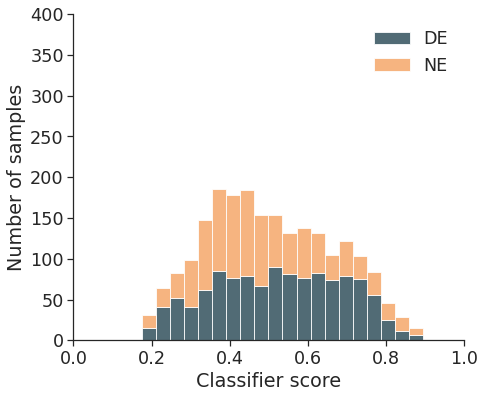

In [105]:
fig, ax = plt.subplots(figsize=(7, 6))

ax.hist([
    df_data[df_data.label==1].dream_score,
    df_data[df_data.label==0].dream_score
], bins=20, histtype='bar', stacked=True, color=[cmap(0), cmap(3)], label=['DE', 'NE'], alpha=0.8)

ax.set_xlim([0, 1])
ax.set_ylim([0, 400])

ax.set_xlabel('Classifier score')
ax.set_ylabel('Number of samples')

ax.legend(frameon=False, loc='best')

ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)

plt.savefig('img/score_distribution.pdf', bbox_inches='tight')


plt.show()